In [1]:
# Setup and imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.abspath('../src'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dml_condition import (
    THETA0, R2_TARGETS,
    generate_plr_data, calibrate_sigma_xi_sq,
    run_dml_plr, run_simulation,
    compute_cell_summary, assign_kappa_regime,
)

print("High-Dimensional DML Study")
print("=" * 40)
print(f"True θ₀ = {THETA0}")
print(f"Setting: n=200, p=500 (p >> n)")

High-Dimensional DML Study
True θ₀ = 1.0
Setting: n=200, p=500 (p >> n)


## 1. Configuration

In [2]:
# Simulation parameters
N_LIST = [200]           # Single sample size
P = 500                   # High-dimensional: p >> n
R2_LIST = [0.75, 0.90, 0.97]  # Three overlap levels
LEARNERS = ["LAS"]        # LASSO only
B = 200                   # Monte Carlo replications
RHO = 0.5                 # Toeplitz correlation
K = 5                     # Cross-fitting folds

print("Configuration")
print("=" * 40)
print(f"n = {N_LIST[0]}, p = {P}")
print(f"R²(D|X) levels: {R2_LIST}")
print(f"Learner: LASSO")
print(f"Replications: B = {B}")
print(f"Total runs: {len(R2_LIST) * B}")

Configuration
n = 200, p = 500
R²(D|X) levels: [0.75, 0.9, 0.97]
Learner: LASSO
Replications: B = 200
Total runs: 600


## 2. Single Replication Check

In [3]:
# Quick check with single replication
print("Single Replication Test (n=200, p=500, LASSO)")
print("=" * 60)
print(f"{'R²(D|X)':<10} {'θ̂':<10} {'κ_DML':<10} {'SE':<10} {'CI':<25} {'Covers?':<8}")
print("-" * 60)

for R2 in R2_LIST:
    Y, D, X, info = generate_plr_data(n=200, p=500, R2_target=R2, rho=RHO, random_state=42)
    result = run_dml_plr(Y, D, X, learner_label='LAS', K=K, random_state=42)
    ci_str = f"[{result.ci_lower:.3f}, {result.ci_upper:.3f}]"
    covers = "Yes" if result.covers(THETA0) else "No"
    print(f"{R2:<10.2f} {result.theta_hat:<10.4f} {result.kappa_dml:<10.3f} "
          f"{result.se_dml:<10.4f} {ci_str:<25} {covers:<8}")

Single Replication Test (n=200, p=500, LASSO)
R²(D|X)    θ̂         κ_DML      SE         CI                        Covers? 
------------------------------------------------------------
0.75       1.0693     0.581      0.0728     [0.927, 1.212]            Yes     
0.90       1.1625     1.704      0.1274     [0.913, 1.412]            Yes     
0.97       1.3479     6.015      0.2398     [0.878, 1.818]            Yes     


## 3. Run Monte Carlo Simulation

In [4]:
%%time

# Run simulation
print("Running Monte Carlo simulation...")
print("=" * 50)

results_df = run_simulation(
    n_list=N_LIST,
    R2_list=R2_LIST,
    learners=LEARNERS,
    B=B,
    rho=RHO,
    p=P,
    K=K,
    verbose=True,
)

print(f"\nComplete! Total rows: {len(results_df)}")

Running Monte Carlo simulation...
DML Condition Number Monte Carlo Study
Design: 1 sample sizes × 3 R² levels × 1 learners
Replications per cell: B = 200
Total replications: 600
Fixed parameters: ρ = 0.5, p = 500, K = 5, θ₀ = 1.0

[1/3] n=200, R²=0.75 (high), learner=LAS
    Completed 100/200 replications
    Completed 200/200 replications

[2/3] n=200, R²=0.9 (moderate), learner=LAS
    Completed 100/200 replications
    Completed 200/200 replications

[3/3] n=200, R²=0.97 (low), learner=LAS
    Completed 100/200 replications
    Completed 200/200 replications

Simulation complete. 600 total replications.

Complete! Total rows: 600
CPU times: user 29min 11s, sys: 54.4 s, total: 30min 6s
Wall time: 8min 5s


## 4. Results Summary

In [5]:
# Compute summary statistics
cell_summary = compute_cell_summary(results_df)
cell_summary['kappa_regime'] = cell_summary['median_kappa'].apply(assign_kappa_regime)

print("Results Summary (n=200, p=500, LASSO)")
print("=" * 80)
print(f"{'R²(D|X)':<10} {'Median κ':<12} {'Coverage':<12} {'Avg CI Len':<12} {'RMSE':<10} {'Regime':<15}")
print("-" * 80)

for _, row in cell_summary.iterrows():
    print(f"{row['R2_target']:<10.2f} {row['median_kappa']:<12.3f} {row['coverage']:<12.3f} "
          f"{row['avg_ci_length']:<12.4f} {row['rmse']:<10.4f} {row['kappa_regime']:<15}")

Results Summary (n=200, p=500, LASSO)
R²(D|X)    Median κ     Coverage     Avg CI Len   RMSE       Regime         
--------------------------------------------------------------------------------
0.75       0.614        0.930        0.3034       0.0876     < 1            
0.90       1.764        0.890        0.5135       0.1585     1-2            
0.97       6.210        0.870        0.9865       0.3382     > 2            


In [6]:
# Detailed statistics by R² level
print("\nDetailed κ_DML Distribution by Overlap Level")
print("=" * 60)

for R2 in R2_LIST:
    subset = results_df[results_df['R2_target'] == R2]
    print(f"\nR²(D|X) = {R2}:")
    print(f"  κ_DML: mean={subset['kappa_dml'].mean():.3f}, "
          f"median={subset['kappa_dml'].median():.3f}, "
          f"sd={subset['kappa_dml'].std():.3f}")
    print(f"  Coverage: {subset['coverage'].mean():.3f}")
    print(f"  CI Length: mean={subset['ci_length'].mean():.4f}")


Detailed κ_DML Distribution by Overlap Level

R²(D|X) = 0.75:
  κ_DML: mean=0.618, median=0.614, sd=0.066
  Coverage: 0.930
  CI Length: mean=0.3034

R²(D|X) = 0.9:
  κ_DML: mean=1.774, median=1.764, sd=0.191
  Coverage: 0.890
  CI Length: mean=0.5135

R²(D|X) = 0.97:
  κ_DML: mean=6.237, median=6.210, sd=0.713
  Coverage: 0.870
  CI Length: mean=0.9865


## 5. Visualization

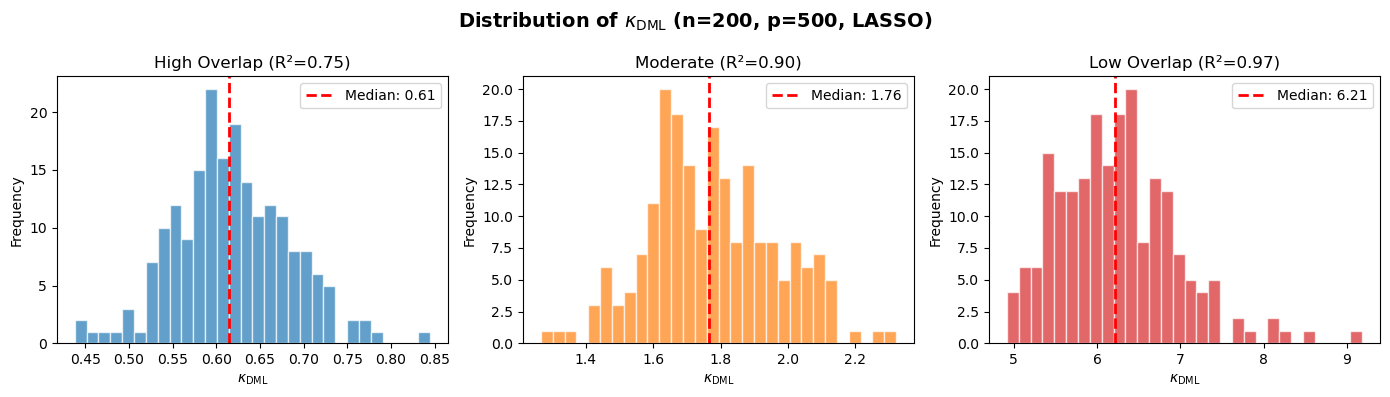

In [7]:
# Plot κ_DML distribution by overlap level
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

colors = {0.75: '#1f77b4', 0.90: '#ff7f0e', 0.97: '#d62728'}
titles = {0.75: 'High Overlap (R²=0.75)', 0.90: 'Moderate (R²=0.90)', 0.97: 'Low Overlap (R²=0.97)'}

for i, R2 in enumerate(R2_LIST):
    subset = results_df[results_df['R2_target'] == R2]
    axes[i].hist(subset['kappa_dml'], bins=30, color=colors[R2], alpha=0.7, edgecolor='white')
    axes[i].axvline(subset['kappa_dml'].median(), color='red', linestyle='--', 
                    linewidth=2, label=f'Median: {subset["kappa_dml"].median():.2f}')
    axes[i].set_xlabel(r'$\kappa_{\mathrm{DML}}$')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(titles[R2])
    axes[i].legend()

plt.suptitle(r'Distribution of $\kappa_{\mathrm{DML}}$ (n=200, p=500, LASSO)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/high_dim_kappa_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

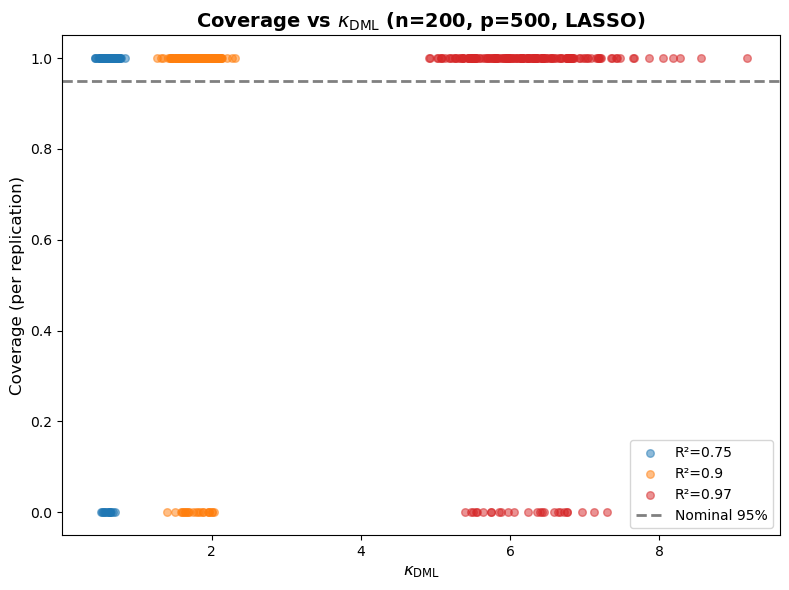

In [8]:
# Coverage vs κ scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

for R2 in R2_LIST:
    subset = results_df[results_df['R2_target'] == R2]
    ax.scatter(subset['kappa_dml'], subset['coverage'], 
               alpha=0.5, label=f'R²={R2}', color=colors[R2], s=30)

ax.axhline(y=0.95, color='gray', linestyle='--', linewidth=2, label='Nominal 95%')
ax.set_xlabel(r'$\kappa_{\mathrm{DML}}$', fontsize=12)
ax.set_ylabel('Coverage (per replication)', fontsize=12)
ax.set_title(r'Coverage vs $\kappa_{\mathrm{DML}}$ (n=200, p=500, LASSO)', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('../results/high_dim_coverage_vs_kappa.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Save Results

In [9]:
# Save results
results_df.to_csv('../results/high_dim_simulation_results.csv', index=False)
cell_summary.to_csv('../results/high_dim_cell_summary.csv', index=False)

print("Results saved:")
print("  - results/high_dim_simulation_results.csv")
print("  - results/high_dim_cell_summary.csv")
print("  - results/high_dim_kappa_distribution.png")
print("  - results/high_dim_coverage_vs_kappa.png")

Results saved:
  - results/high_dim_simulation_results.csv
  - results/high_dim_cell_summary.csv
  - results/high_dim_kappa_distribution.png
  - results/high_dim_coverage_vs_kappa.png


In [10]:
# Final summary
print("\n" + "=" * 60)
print("HIGH-DIMENSIONAL STUDY COMPLETE")
print("=" * 60)
print(f"Setting: n={N_LIST[0]}, p={P} (ratio p/n = {P/N_LIST[0]:.1f})")
print(f"Replications: {B}")
print("\nKey Findings:")
for _, row in cell_summary.iterrows():
    print(f"  R²={row['R2_target']:.2f}: κ={row['median_kappa']:.2f}, "
          f"Coverage={row['coverage']:.1%}, Regime={row['kappa_regime']}")


HIGH-DIMENSIONAL STUDY COMPLETE
Setting: n=200, p=500 (ratio p/n = 2.5)
Replications: 200

Key Findings:
  R²=0.75: κ=0.61, Coverage=93.0%, Regime=< 1
  R²=0.90: κ=1.76, Coverage=89.0%, Regime=1-2
  R²=0.97: κ=6.21, Coverage=87.0%, Regime=> 2
